In [5]:
import json
import collections as cl
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import os
import sys
import io
import matplotlib.pyplot as plt

In [169]:
class COCOevalDet(COCO):
    def __init__(self, cocoGt_file=None, cocoDt_file=None, eval_file=None):
        super().__init__()

        assert self.initialize(cocoGt_file, cocoDt_file, eval_file)
        self.type =  ['Match', 'LC', 'DC', 'Cls', 'Loc', 'Bkg', 'Miss']
        self.type_order =  {'Match':0, 'LC':1, 'DC':1, 'Cls':2, 'Loc':3, 'Bkg':4, 'Miss':4, None:5}
        # self.recall_points = np.arange(0, 1.1, 0.1)
        self.recall_points = np.arange(0, 1.01, 0.1)
        self.cats = self.cocoGt.loadCats(self.cocoGt.getCatIds())



    def initialize(self, cocoGt_file, cocoDt_file, eval_file):
        
        self.iou_thresh = 0.5
        self.iou_loc = 0.2
        self.is_evaluated = False

        if cocoGt_file is not None and cocoDt_file is not None:
          if os.path.isfile(cocoGt_file) and os.path.isfile(cocoDt_file):
            self.cocoGt = COCO(cocoGt_file)
            self.cocoDt = self.cocoGt.loadRes(cocoDt_file)
            self.out_dir = os.path.dirname(cocoGt_file)

            eval_dict = {'eval': {'count': None, 'type': None, 'corr_id': None, 'iou': None}}
            _gts = self.cocoGt.loadAnns(self.cocoGt.getAnnIds())
            _dts = self.cocoDt.loadAnns(self.cocoDt.getAnnIds())
            _ = [g.update(eval_dict) for g in _gts]
            _ = [d.update(eval_dict) for d in _dts]
            return True

        elif eval_file is not None:
          if os.path.isfile(eval_file):
            self.cocoGt = COCO(eval_file)
            _cocoDt = json.load(open(eval_file))['detections']
            self.cocoDt = self.cocoGt.loadRes(_cocoDt)
            self.is_evaluated = True
            self.out_dir = os.path.dirname(eval_file)
          return True
        else:
          print('ERROR:Could not read files')
          return False
      
    def eval(self):
      if self.is_evaluated == False:
        img_ids = self.cocoGt.getImgIds()
        for img_id in img_ids:
          self.eval_per_img(img_id)
        self.is_evaluated = True
      else:
        print("Already evaluated")

    def eval_per_img(self, imgId):

        Id_gts = self.cocoGt.getAnnIds(imgIds=imgId, iscrowd=None)
        Id_dts = self.cocoDt.getAnnIds(imgIds=imgId, iscrowd=None)

        gts = self.cocoGt.loadAnns(Id_gts)
        dts = self.cocoDt.loadAnns(Id_dts)
        
        # Sort detections by score
        inds = np.argsort([-d['score'] for d in dts], kind='mergesort')
        dts = [dts[i] for i in inds]

        exist_gts = bool(gts)
        exist_dts = bool(dts)


        if exist_gts and exist_dts:
           
          for gt in gts:
            bb_gt = np.array(gt["bbox"])
            bb_dts = np.array([dt["bbox"] for dt in dts])

            iou = self.iou_per_single_gt(bb_gt, bb_dts)
            
            TP_all_cat_boolean = iou >self.iou_thresh
            TP_loc_all_cat_boolean = iou >self.iou_loc

            cat_gt = np.array(gt['category_id'])
            cat_dts = np.array([dt['category_id'] for dt in dts])
            cat_match_boolean = cat_dts == cat_gt

            TP_boolean = cat_match_boolean & TP_all_cat_boolean
            TP_loc_boolean = cat_match_boolean & TP_loc_all_cat_boolean
            TP_cat_boolean = cat_match_boolean &  False*TP_boolean

            # Count TP, double count and  less counts(LC)
            id_dets_match = np.where(TP_boolean==True)[0]
            for id_det in id_dets_match:
              dt = dts[id_det]
              ## TP if gt is not assinged and dt is not TP-
              if gt['eval']['count'] != "TP" and dt['eval']['count'] != "TP":
                dt['eval'] = {"count":"TP", "type":"Match", "corr_id": gt['id'], 'iou':iou[id_det]}
                gt['eval'] = {"count":"TP", "type":"Match","corr_id": dt['id'],'iou':iou[id_det]}
                continue
              # Double count if gt_assigned is assigned
              elif gt['eval']['count'] == "TP" and dt['eval']['count'] != "TP":
                dt['eval'] = {"count":"FP", "type":"DC", "corr_id": gt['id'],'iou':iou[id_det]}
              ## Less count(LC) if all detections are already assigned 
              if id_det == id_dets_match[-1]:
                if gt['eval']['count'] != "TP" and dt['eval']['count'] == "TP":
                  gt['eval'] = {"count":"FN", "type":"LC","corr_id": dts[id_dets_match[0]]['id'],'iou':iou[id_det]}
              
            # Count catgory mistakes
            id_dets_all = np.where(TP_cat_boolean==True)[0]
            for id_det in id_dets_all:
              dt = dts[id_det]
              if self.type_order[dt['eval']['type']] > self.type_order['Cls']:
                dt['eval'] = {"count":"FP", "type":"Cls", "corr_id": gt['id'],'iou':iou[id_det]}
              if self.type_order[gt['eval']['type']] > self.type_order['Cls']:
                gt['eval'] = {"count":"FN", "type":"Cls","corr_id": dt['id'],'iou':iou[id_det]}

            # Count location error
            id_dets_loc = np.where(TP_loc_boolean==True)[0]
            for id_det in id_dets_loc:
              dt = dts[id_det]
              if self.type_order[dt['eval']['type']] > self.type_order['Loc']:
                dt['eval'] = {"count":"FP", "type":"Loc", "corr_id": gt['id'],'iou':iou[id_det]}
              if self.type_order[gt['eval']['type']] > self.type_order['Loc']:
                gt['eval'] = {"count":"FN", "type":"Loc","corr_id": dt['id'],'iou':iou[id_det]}

            # No match
            if  self.type_order[gt['eval']['type']] > self.type_order[None]:
              gt['eval'] = {"count":"FN", "type":"Miss","corr_id":None,'iou':None}

          # Count Bkg, if detections are not assigned yet
          for dt in dts:
            if  self.type_order[dt['eval']['type']] > self.type_order[None]:
              dt['eval'] = {"count":"FP", "type":"Bkg", "corr_id": None,'iou':None}

        else:
          if exist_gts and not exist_dts:
            for gt in gts:
                gt['eval'] = {"count":"FN", "type":"Miss","corr_id": None,'iou':None}
        
          elif not exist_gts and exist_dts:
            for dt in dts:
                dt['eval'] = {"count":"FP", "type":"Bkg","corr_id": None,'iou':None}

    def iou_per_single_gt(self, gt_bb, dt_bbs):

      gt_area = (gt_bb[2]  + 1) \
               * (gt_bb[3]  + 1)

      dt_areas = (dt_bbs[:,2]  + 1) \
               * (dt_bbs[:,3]  + 1)

      abx_min = np.maximum(gt_bb[0], dt_bbs[:,0]) # xmin
      aby_min = np.maximum(gt_bb[1], dt_bbs[:,1]) # ymin
      abx_max = np.minimum(gt_bb[0] + gt_bb[2], dt_bbs[:,0] + dt_bbs[:,2]) # xmax
      aby_max = np.minimum(gt_bb[1] + gt_bb[3], dt_bbs[:,1] + dt_bbs[:,3]) # ymax

      w = np.maximum(0, abx_max - abx_min + 1)
      h = np.maximum(0, aby_max - aby_min + 1)
      intersect = w*h

      iou = intersect / (gt_area + dt_areas - intersect)
      return iou

    def dump_json(self, output_file):
      
        def images(cocoGt):
            img_ids = cocoGt.getImgIds()
            return cocoGt.loadImgs(ids=img_ids)

        def categories(cocoGt):
          return cocoGt.loadCats(cocoGt.getCatIds())
        
        def annotations(cocoGt):
            annIds = cocoGt.getAnnIds()
            return cocoGt.loadAnns(ids=annIds)

        def detections(cocoDt):
            annIds = cocoDt.getAnnIds()
            return cocoDt.loadAnns(ids=annIds)

        query_list = ["licenses", "info", "categories", "images", "annotations", "detections","segment_info"]
        js = cl.OrderedDict()
        for i in range(len(query_list)):
          tmp = ""
          if query_list[i]== "categories":
            tmp = categories(self.cocoGt) 
          if query_list[i]== "images":
            tmp = images(self.cocoGt) 
          if query_list[i]== "annotations":
            tmp = annotations(self.cocoGt) 
          if query_list[i]== "detections":
            tmp = detections(self.cocoDt) 
          # save it
          js[query_list[i]] = tmp
        # write
        fw = open(output_file,'w')
        json.dump(js,fw,indent=2)


    def precision_analyze(self):
      for cat_id in self.cocoGt.getCatIds():

        dt_ids = self.cocoDt.getAnnIds(catIds=cat_id)
        dts = self.cocoDt.loadAnns(ids=dt_ids)
        counts = {'Loc':0, 'DC':0, 'LC':0, 'Cls':0, 'Bkg':0, 'Miss':0}
        num_dts = len(dts)

        for type in self.type:
           _count = len([dt for dt in dts if dt['eval']['count'] == 'type'])
           counts[type] = _count

        counts_v = [c for c in counts.values()]
        counts_k = [k for k in counts.keys()]

        catetroy_name = self.cats[cat_id-1]['name']
        fig_pie, ax_pie = plt.subplots()
        ax_pie.set_title(catetroy_name + "_Precision_ratio")
        ax_pie.pie(counts_v, labels=counts_k, autopct="%1.1f %%")
        fig_pie.savefig(os.path.join(self.out_dir, catetroy_name + "_precision_ratio.png")) 

        




    def accumulate(self):
      for cat_id in self.cocoGt.getCatIds():
        dt_ids = self.cocoDt.getAnnIds(catIds=cat_id)
        gt_ids = self.cocoGt.getAnnIds(catIds=cat_id)
        dts = self.cocoDt.loadAnns(ids=dt_ids)
        gts = self.cocoGt.loadAnns(ids=gt_ids)
        num_gts = len(gts)
        inds = np.argsort([-d['score'] for d in dts], kind='mergesort')
        dts = [dts[i] for i in inds]
      
        x_conf =[1]
        y_pres =[1]
        y_recall =[0]
        count_TP = 0
        # FPs = {'Loc':0, 'DC':0, 'LC':0, 'Cls':0, 'Bkg':0, 'Miss':0}
        for id, dt in enumerate(dts):
            x_conf.append(dt['score'])
            if dt['eval']['count'] == 'TP':
                count_TP += 1
            # else:
            #   for k in FPs.keys():
            #       if k == dt['eval']['type']:
            #         FPs[k]+=1

            # 
            y_pres.append(count_TP / (id +1))
            y_recall.append(count_TP / num_gts)
        

        x_conf.append(0)
        y_pres.append(0)
        y_recall.append(1)

        y_pres_ = np.zeros(self.recall_points.shape)
        ids = np.searchsorted(y_recall, self.recall_points, side='left')

        for i, id in enumerate(ids):
          y_pres_[i] = y_pres[id]
        y_pres_ = np.maximum.accumulate(y_pres_[::-1])[::-1]


        fig_conf, ax_conf = plt.subplots()
        ax_conf.plot(x_conf, y_pres, color='red')
        ax_conf.plot(x_conf, y_recall,color='green')
        ax_conf.legend(["Precision", "Recall"])
        ax_conf.set_xlabel('confidence')
        fig_conf.savefig(os.path.join(self.out_dir,  "pr_conf.png")) 

        fig_pr, ax_pr = plt.subplots()

        ax_pr.plot(y_recall, y_pres, marker='.')
        ax_pr.plot(self.recall_points, y_pres_, marker='x', linewidth=0)
        ax_pr.set_xlabel('Precision')
        ax_pr.set_xlabel('Recall')
        ax_pr.legend(["PR_raw", "PR_inter"])

        fig_pr.savefig(os.path.join(self.out_dir,  "pr_curve.png")) 
        ap = 0
        for i in range(1, len(y_pres_)):
          ap += y_pres_[i]*(self.recall_points[i] - self.recall_points[i-1])
        print(ap)




In [170]:
path_to_coco_dir = "/home/ryota/nn_git/evaluation/map/dog/coco"
path_to_gt = os.path.join(path_to_coco_dir, 'gt.json')
path_to_dt = os.path.join(path_to_coco_dir, 'dt.json')

cocoEvalDet = COCOevalDet(path_to_gt, path_to_dt)
cocoEvalDet.eval()
cocoEvalDet.dump_json(os.path.join(path_to_coco_dir, 'test.json'))



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


<ipython-input-169-17a30ef910bb>:216: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax_pie.pie(counts_v, labels=counts_k, autopct="%1.1f %%")


AttributeError: 'Figure' object has no attribute 'plot'

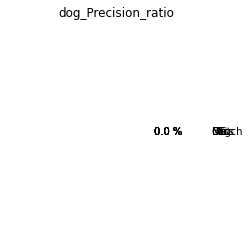

In [171]:
cocoEvalDet.precision_analyze()

[{'id': 1, 'name': 'dog', 'supercategory': ''}, {'id': 2, 'name': 'person', 'supercategory': ''}]
0.54
1.0


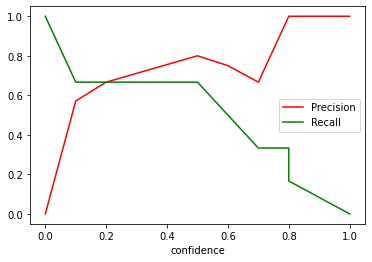

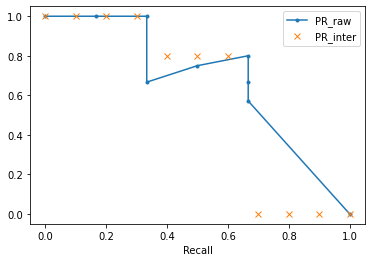

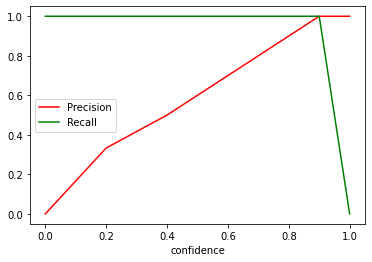

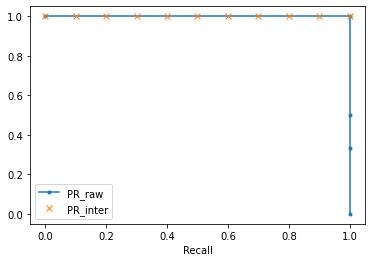

In [151]:
cocoEvalDet.accumulate()

In [102]:
cocoEvalDet.cocoDt.loadA(catIds=1)

AttributeError: 'COCO' object has no attribute 'loadA'

In [162]:
cocoEvalDet.cats[1]['name']

'person'